# code to read data and put into pandas

In [16]:
#import all the necessary packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
sns.set()

In [6]:
#set the working and the data directories
path = os.getcwd()
pathdata = path+'/Data'
os.chdir(pathdata)

In [7]:
#read the excel file with dates for the forecasts
dates = pd.read_excel('SPF_rounds_dates.xlsx')
new_header = dates.iloc[0] 
dates = dates[1:] 
dates.columns = new_header
dates = dates.dropna()

In [8]:
#get all the unique dates
dates['Deadline to reply'].unique()

array([datetime.datetime(1999, 2, 12, 0, 0),
       datetime.datetime(1999, 5, 3, 0, 0),
       datetime.datetime(1999, 8, 6, 0, 0),
       datetime.datetime(1999, 11, 3, 0, 0),
       datetime.datetime(2000, 2, 9, 0, 0),
       datetime.datetime(2000, 5, 5, 0, 0),
       datetime.datetime(2000, 8, 4, 0, 0),
       datetime.datetime(2000, 11, 2, 0, 0),
       datetime.datetime(2001, 2, 1, 0, 0),
       datetime.datetime(2001, 5, 3, 0, 0),
       datetime.datetime(2001, 8, 3, 0, 0),
       datetime.datetime(2001, 10, 29, 0, 0),
       datetime.datetime(2002, 2, 4, 0, 0),
       datetime.datetime(2002, 4, 22, 0, 0),
       datetime.datetime(2002, 7, 22, 0, 0),
       datetime.datetime(2002, 10, 23, 0, 0),
       datetime.datetime(2003, 1, 27, 0, 0),
       datetime.datetime(2003, 4, 24, 0, 0),
       datetime.datetime(2003, 7, 23, 0, 0),
       datetime.datetime(2003, 10, 28, 0, 0),
       datetime.datetime(2004, 1, 28, 0, 0),
       datetime.datetime(2004, 4, 26, 0, 0),
       datetime.

# Creating the inflation dataframe

In [9]:
##initiate an empty dataframe for the forecats
##create new dataframe
df = pd.DataFrame(columns=['SurveyDate', 'Source','Current Year', 'One Year Ahead', 'Two Years Ahead','Rolling1', 'Rolling2', 'Longer Term'])
df['SurveyDate'] = dates['Deadline to reply'].repeat(128)
for each_date in dates['Deadline to reply'].unique():
    df.loc[df.SurveyDate == each_date,'Source'] = list(range(1,129))
#dictionary for the quarters
dqs = {'Q1':'Dec',
      'Q2':'Mar',
      'Q3':'Jun',
      'Q4':'Sep'}

we have to iterate over all the CSV files

In [10]:
#for each date (forecast) in the list, get all the point estimates
for curr_forecast in dates['Deadline to reply'].tolist():
    print(curr_forecast)
    date_curr =  dates.loc[dates['Deadline to reply']==curr_forecast]['SPF round'].to_string().rsplit(' ', 1)[1]
    curr_csv = date_curr+".csv"
    currq = date_curr[-2:]
    df_curr = pd.read_csv(curr_csv)
    index_changes = df_curr.loc[df_curr['INFLATION EXPECTATIONS; YEAR-ON-YEAR CHANGE IN HICP'].isnull()].index
    df_infl = df_curr.loc[0:index_changes[0]-1,:]
    new_header = df_infl.iloc[0] #grab the first row for the header
    df_infl = df_infl[1:] #take the data less the header row
    df_infl.columns = new_header #set the header row as the df header
    df_infl.dropna(subset=['POINT'])
    df_infl.dropna(axis='columns', how='all')
    df_infl_point = df_infl[['TARGET_PERIOD', 'FCT_SOURCE', 'POINT']]
    sources_list = np.array(df_infl_point['FCT_SOURCE'].unique().astype(int))
    t1 = str(curr_forecast.year)
    t2 = str(curr_forecast.year+1)
    t6 = str(curr_forecast.year+2)    
    if (currq=='Q1' or currq=='Q2'):
        t3 = str(curr_forecast.year+4)
    else:
        t3 = str(curr_forecast.year+5)
    if (currq=='Q1'):
        t4 = str(curr_forecast.year)+dqs[currq]
        t5 = str(curr_forecast.year+1)+dqs[currq]
    else:
        t4 = str(curr_forecast.year+1)+dqs[currq]
        t5 = str(curr_forecast.year+2)+dqs[currq]
#sources_list
    for each_source in sources_list:
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Current Year"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t1) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"One Year Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t2) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if len(df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6)]) > 0:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Two Years Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values 
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling1"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t4) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        

1999-02-12 00:00:00
1999-05-03 00:00:00
1999-08-06 00:00:00
1999-11-03 00:00:00
2000-02-09 00:00:00
2000-05-05 00:00:00
2000-08-04 00:00:00
2000-11-02 00:00:00
2001-02-01 00:00:00
2001-05-03 00:00:00
2001-08-03 00:00:00
2001-10-29 00:00:00
2002-02-04 00:00:00
2002-04-22 00:00:00
2002-07-22 00:00:00
2002-10-23 00:00:00
2003-01-27 00:00:00
2003-04-24 00:00:00
2003-07-23 00:00:00
2003-10-28 00:00:00
2004-01-28 00:00:00
2004-04-26 00:00:00
2004-07-26 00:00:00
2004-10-21 00:00:00
2005-01-26 00:00:00
2005-04-22 00:00:00
2005-07-22 00:00:00
2005-10-24 00:00:00
2006-01-23 00:00:00
2006-04-26 00:00:00
2006-07-21 00:00:00
2006-10-20 00:00:00
2007-01-24 00:00:00
2007-04-23 00:00:00
2007-07-18 00:00:00
2007-10-18 00:00:00
2008-01-18 00:00:00
2008-04-18 00:00:00
2008-07-18 00:00:00
2008-10-17 00:00:00
2009-01-20 00:00:00
2009-04-20 00:00:00
2009-07-17 00:00:00
2009-10-19 00:00:00
2010-01-19 00:00:00
2010-04-20 00:00:00
2010-07-19 00:00:00
2010-10-19 00:00:00
2011-01-18 00:00:00
2011-04-19 00:00:00


In [15]:
#print the top 5 rows of the df
df.head(5)

,SurveyDate,Source,Current Year,One Year Ahead,Two Years Ahead,Rolling1,Rolling2,Longer Term
3,1999-02-12,1,1,1.5,NaN,1.2,1.7,1.8
3,1999-02-12,2,1,1.2,NaN,1.2,1.2,1.6
3,1999-02-12,3,.8,1,NaN,.8,1.2,1.7
3,1999-02-12,4,1.2,1.6,NaN,1.3,1.8,2
3,1999-02-12,5,.8,1.4,NaN,1.1,1.5,1.8


In [17]:
#saving the inflation dataframe
df_infl = df.copy()
df_infl.to_pickle('infl_data.pkl')

# GDP

In [18]:
##initiate df for the forecats
##create new dataframe
df = pd.DataFrame(columns=['SurveyDate', 'Source','Current Year', 'One Year Ahead', 'Two Years Ahead','Rolling1', 'Rolling2', 'Longer Term'])
df['SurveyDate'] = dates['Deadline to reply'].repeat(128)
for each_date in dates['Deadline to reply'].unique():
    df.loc[df.SurveyDate == each_date,'Source'] = list(range(1,129))
dqs = {'Q1':'Q3',
      'Q2':'Q4',
      'Q3':'Q1',
      'Q4':'Q2'}

In [19]:
for curr_forecast in dates['Deadline to reply'].tolist():
    print(curr_forecast)
    date_curr =  dates.loc[dates['Deadline to reply']==curr_forecast]['SPF round'].to_string().rsplit(' ', 1)[1]
    curr_csv = date_curr+".csv"
    currq = date_curr[-2:]
    df_curr = pd.read_csv(curr_csv)
    #df_curr['INFLATION EXPECTATIONS; YEAR-ON-YEAR CHANGE IN HICP'].unique()
    index_changes = df_curr.loc[df_curr['INFLATION EXPECTATIONS; YEAR-ON-YEAR CHANGE IN HICP'].isnull()].index
    if len(index_changes)==4:
        df_infl = df_curr.loc[index_changes[1]+1:index_changes[2]-1,:]
    else:
        df_infl = df_curr.loc[index_changes[2]+1:index_changes[3]-1,:]
    new_header = df_infl.iloc[1] #grab the first row for the header
    df_infl = df_infl[2:] #take the data less the header row
    df_infl.columns = new_header #set the header row as the df header
    df_infl.dropna(subset=['POINT'])
    df_infl.dropna(axis='columns', how='all')
    df_infl_point = df_infl[['TARGET_PERIOD', 'FCT_SOURCE', 'POINT']]
    #horizons = df_infl_point["TARGET_PERIOD"].unique()
    #if len(horizons)==6:
    #    horizons = horizons[[0, 2, 4]]
    sources_list = np.array(df_infl_point['FCT_SOURCE'].unique().astype(int))
    t1 = str(curr_forecast.year)
    t2 = str(curr_forecast.year+1)
    t6 = str(curr_forecast.year+2)
    if (currq=='Q1' or currq=='Q2'):
        t3 = str(curr_forecast.year+4)
    else:
        t3 = str(curr_forecast.year+5)
    if (currq=='Q1' or currq=='Q2'):
        t4 = str(curr_forecast.year)+dqs[currq]
        t5 = str(curr_forecast.year+1)+dqs[currq]
    else:
        t4 = str(curr_forecast.year+1)+dqs[currq]
        t5 = str(curr_forecast.year+2)+dqs[currq]
#sources_list
    for each_source in sources_list:
        if (curr_csv == '2008Q2.csv') & (each_source ==92 ):
            continue 
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Current Year"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t1) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"One Year Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t2) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if len(df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6)]) > 0:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Two Years Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values 
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling1"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t4) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values

1999-02-12 00:00:00
1999-05-03 00:00:00
1999-08-06 00:00:00
1999-11-03 00:00:00
2000-02-09 00:00:00
2000-05-05 00:00:00
2000-08-04 00:00:00
2000-11-02 00:00:00
2001-02-01 00:00:00
2001-05-03 00:00:00
2001-08-03 00:00:00
2001-10-29 00:00:00
2002-02-04 00:00:00
2002-04-22 00:00:00
2002-07-22 00:00:00
2002-10-23 00:00:00
2003-01-27 00:00:00
2003-04-24 00:00:00
2003-07-23 00:00:00
2003-10-28 00:00:00
2004-01-28 00:00:00
2004-04-26 00:00:00
2004-07-26 00:00:00
2004-10-21 00:00:00
2005-01-26 00:00:00
2005-04-22 00:00:00
2005-07-22 00:00:00
2005-10-24 00:00:00
2006-01-23 00:00:00
2006-04-26 00:00:00
2006-07-21 00:00:00
2006-10-20 00:00:00
2007-01-24 00:00:00
2007-04-23 00:00:00
2007-07-18 00:00:00
2007-10-18 00:00:00
2008-01-18 00:00:00
2008-04-18 00:00:00
2008-07-18 00:00:00
2008-10-17 00:00:00
2009-01-20 00:00:00
2009-04-20 00:00:00
2009-07-17 00:00:00
2009-10-19 00:00:00
2010-01-19 00:00:00
2010-04-20 00:00:00
2010-07-19 00:00:00
2010-10-19 00:00:00
2011-01-18 00:00:00
2011-04-19 00:00:00


In [20]:
df_gdp = df.copy()
df_gdp.to_pickle('gdp_data.pkl')

# unemployment

In [21]:
##initiate df for the forecats
##create new dataframe
df = pd.DataFrame(columns=['SurveyDate', 'Source','Current Year', 'One Year Ahead', 'Two Years Ahead','Rolling1', 'Rolling2', 'Longer Term'])
df['SurveyDate'] = dates['Deadline to reply'].repeat(128)
for each_date in dates['Deadline to reply'].unique():
    df.loc[df.SurveyDate == each_date,'Source'] = list(range(1,129))
#sources = pd.Series(list(range(1,129))).repeat(len(dates['Deadline to reply'].tolist()))
#sources.index = df.index
#df['Source'] = sources
dqs = {'Q1':'Nov',
      'Q2':'Feb',
      'Q3':'May',
      'Q4':'Aug'}
df

,SurveyDate,Source,Current Year,One Year Ahead,Two Years Ahead,Rolling1,Rolling2,Longer Term
3,1999-02-12,1,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-02-12,2,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-02-12,3,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-02-12,4,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-02-12,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
87,2020-01-13,124,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,125,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,126,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,127,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for curr_forecast in dates['Deadline to reply'].tolist():
    print(curr_forecast)
    date_curr =  dates.loc[dates['Deadline to reply']==curr_forecast]['SPF round'].to_string().rsplit(' ', 1)[1]
    curr_csv = date_curr+".csv"
    currq = date_curr[-2:]
    qs = dqs[currq]
    if curr_csv=='2000Q1.csv':
        qs = 'Dec'
    df_curr = pd.read_csv(curr_csv)
    #df_curr['INFLATION EXPECTATIONS; YEAR-ON-YEAR CHANGE IN HICP'].unique()
    index_changes = df_curr.loc[df_curr['INFLATION EXPECTATIONS; YEAR-ON-YEAR CHANGE IN HICP'].isnull()].index
    if len(index_changes)==4:
        df_infl = df_curr.loc[index_changes[2]+1:index_changes[3]-1,:]
    else:
        df_infl = df_curr.loc[index_changes[3]+1:index_changes[4]-1,:]
    new_header = df_infl.iloc[1] #grab the first row for the header
    df_infl = df_infl[2:] #take the data less the header row
    df_infl.columns = new_header #set the header row as the df header
    df_infl.dropna(subset=['POINT'])
    df_infl.dropna(axis='columns', how='all')
    df_infl_point = df_infl[['TARGET_PERIOD', 'FCT_SOURCE', 'POINT']]
    #horizons = df_infl_point["TARGET_PERIOD"].unique()
    #if len(horizons)==6:
    #    horizons = horizons[[0, 2, 4]]
    sources_list = np.array(df_infl_point['FCT_SOURCE'].unique().astype(int))
    t1 = str(curr_forecast.year)
    t2 = str(curr_forecast.year+1)
    t6 = str(curr_forecast.year+2)
    if (currq=='Q1' or currq=='Q2'):
        t3 = str(curr_forecast.year+4)
    else:
        t3 = str(curr_forecast.year+5)
    if (currq=='Q1'):
        t4 = str(curr_forecast.year)+qs
        t5 = str(curr_forecast.year+1)+qs
    else:
        t4 = str(curr_forecast.year+1)+qs
        t5 = str(curr_forecast.year+2)+qs
#sources_list
    for each_source in sources_list:
        if (curr_csv == '2008Q2.csv') & (each_source ==92 ):
            continue 
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Current Year"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t1) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"One Year Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t2) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if len(df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6)]) > 0:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Two Years Ahead"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t6) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values 
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Longer Term"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t3) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling1"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t4) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values
        if df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5)].empty:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = np.nan
        else:
            df.loc[(df.SurveyDate == curr_forecast) & (df.Source==each_source),"Rolling2"] = df_infl_point.loc[(df_infl_point['TARGET_PERIOD']==t5) & (df_infl_point['FCT_SOURCE']==each_source.astype(str))]['POINT'].values

1999-02-12 00:00:00
1999-05-03 00:00:00
1999-08-06 00:00:00
1999-11-03 00:00:00
2000-02-09 00:00:00
2000-05-05 00:00:00
2000-08-04 00:00:00
2000-11-02 00:00:00
2001-02-01 00:00:00
2001-05-03 00:00:00
2001-08-03 00:00:00
2001-10-29 00:00:00
2002-02-04 00:00:00
2002-04-22 00:00:00
2002-07-22 00:00:00
2002-10-23 00:00:00
2003-01-27 00:00:00
2003-04-24 00:00:00
2003-07-23 00:00:00
2003-10-28 00:00:00
2004-01-28 00:00:00
2004-04-26 00:00:00
2004-07-26 00:00:00
2004-10-21 00:00:00
2005-01-26 00:00:00
2005-04-22 00:00:00
2005-07-22 00:00:00
2005-10-24 00:00:00
2006-01-23 00:00:00
2006-04-26 00:00:00
2006-07-21 00:00:00
2006-10-20 00:00:00
2007-01-24 00:00:00
2007-04-23 00:00:00
2007-07-18 00:00:00
2007-10-18 00:00:00
2008-01-18 00:00:00
2008-04-18 00:00:00
2008-07-18 00:00:00
2008-10-17 00:00:00
2009-01-20 00:00:00
2009-04-20 00:00:00
2009-07-17 00:00:00
2009-10-19 00:00:00
2010-01-19 00:00:00
2010-04-20 00:00:00
2010-07-19 00:00:00
2010-10-19 00:00:00
2011-01-18 00:00:00
2011-04-19 00:00:00


In [12]:
df

,SurveyDate,Source,Current Year,One Year Ahead,Two Years Ahead,Rolling1,Rolling2,Longer Term
3,1999-02-12,1,10.2,10,NaN,10.2,9.8,9
3,1999-02-12,2,10,9.8,NaN,10,9.7,9.2
3,1999-02-12,3,10.7,10.8,NaN,10.9,10.5,9.3
3,1999-02-12,4,11,10.6,NaN,11,10.4,10
3,1999-02-12,5,9.9,9.8,NaN,9.9,9.7,9.4
...,...,...,...,...,...,...,...,...
87,2020-01-13,124,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,125,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,126,NaN,NaN,NaN,NaN,NaN,NaN
87,2020-01-13,127,7.5,7.7,7.6,7.6,7.7,7.5


In [23]:
df_un = df.copy()
df_un.to_pickle('un_data.pkl')

# plot forecasts in time

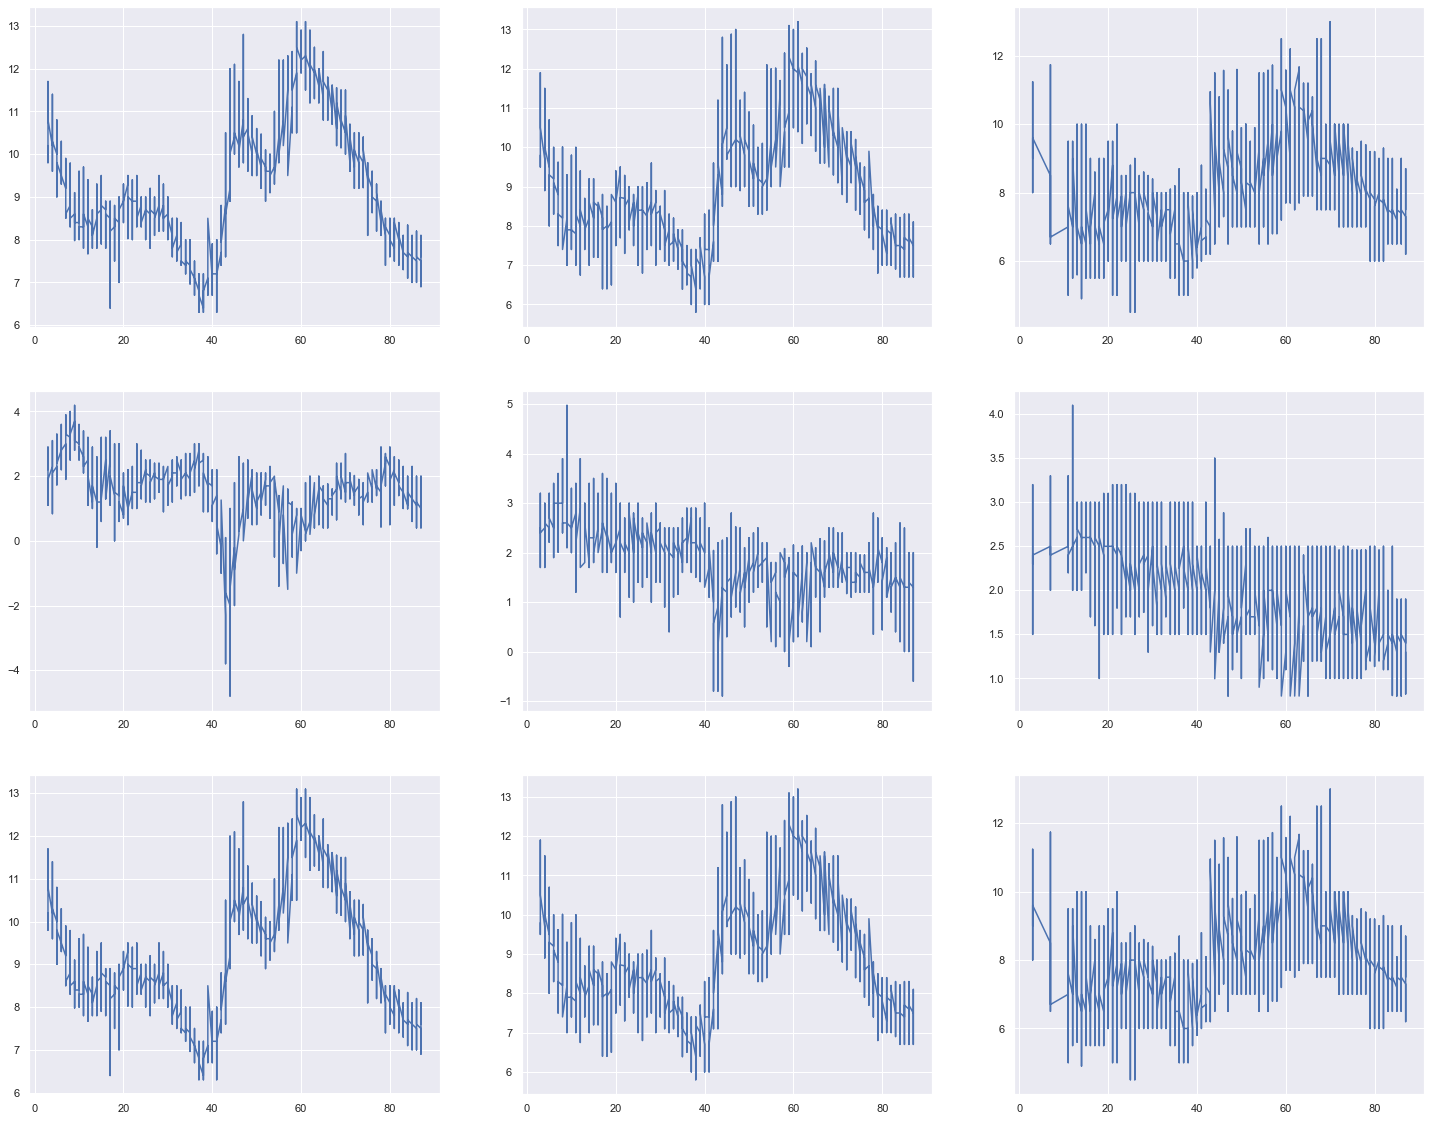

In [24]:
sns.set()
fig, axs = plt.subplots(3, 3, figsize=(25, 20))
axs[0,0].plot(df['Rolling1'].dropna().astype(float))
axs[0,1].plot(df['Rolling2'].dropna().astype(float))
axs[0,2].plot(df['Longer Term'].dropna().astype(float))
axs[1,0].plot(df_gdp['Rolling1'].dropna().astype(float))
axs[1,1].plot(df_gdp['Rolling2'].dropna().astype(float))
axs[1,2].plot(df_gdp['Longer Term'].dropna().astype(float))
axs[2,0].plot(df_un['Rolling1'].dropna().astype(float))
axs[2,1].plot(df_un['Rolling2'].dropna().astype(float))
axs[2,2].plot(df_un['Longer Term'].dropna().astype(float))

# forecasts histograms

(array([ 11., 109., 685., 698., 801., 481., 203.,  68.,  16.,   5.]),
 array([ 4.5 ,  5.35,  6.2 ,  7.05,  7.9 ,  8.75,  9.6 , 10.45, 11.3 ,
        12.15, 13.  ]),
 <a list of 10 Patch objects>)

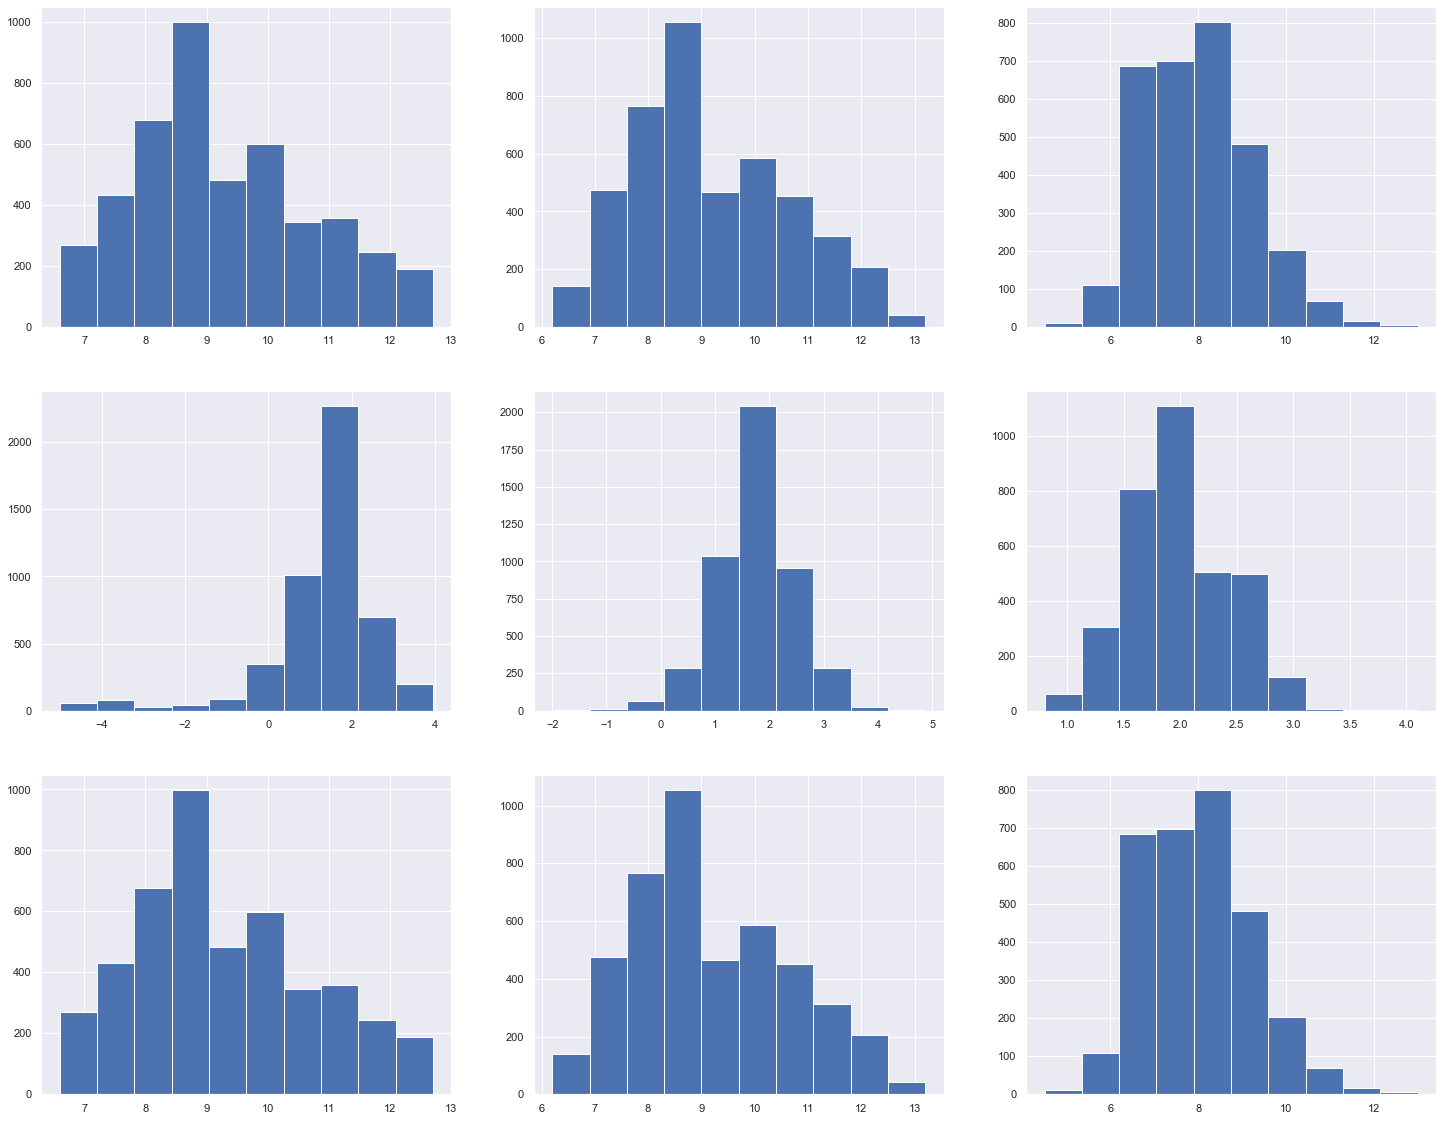

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(25, 20))
axs[0,0].hist(df['Current Year'].dropna().astype(float))
axs[0,1].hist(df['One Year Ahead'].dropna().astype(float))
axs[0,2].hist(df['Longer Term'].dropna().astype(float))
axs[1,0].hist(df_gdp['Current Year'].dropna().astype(float))
axs[1,1].hist(df_gdp['One Year Ahead'].dropna().astype(float))
axs[1,2].hist(df_gdp['Longer Term'].dropna().astype(float))
axs[2,0].hist(df_un['Current Year'].dropna().astype(float))
axs[2,1].hist(df_un['One Year Ahead'].dropna().astype(float))
axs[2,2].hist(df_un['Longer Term'].dropna().astype(float))